Cargando datos procesados...

=== INFORMACIÓN DEL DATAFRAME ===
Shape: (2947428, 27)

Columnas disponibles:
['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'is_holiday', 'trans_lag_16', 'trans_lag_21', 'trans_roll_mean_7', 'trans_roll_mean_14', 'trans_roll_mean_28', 'month', 'day_of_week', 'year', 'is_weekend', 'sales_lag_16', 'sales_lag_21', 'sales_lag_30', 'sales_roll_mean_7', 'sales_roll_mean_14', 'sales_roll_mean_30']

¿Está is_holiday?: True
Iniciando entrenamiento en GPU con Target Logarítmico...
[0]	validation_0-rmse:3.02748
[200]	validation_0-rmse:0.65200
[400]	validation_0-rmse:0.62007
[600]	validation_0-rmse:0.60696
[800]	validation_0-rmse:0.59940
[1000]	validation_0-rmse:0.59582
[1200]	validation_0-rmse:0.59305
[1277]	validation_0-rmse:0.59259

RMSLE en Validación (con Log): 0.5925


<Figure size 1000x600 with 0 Axes>

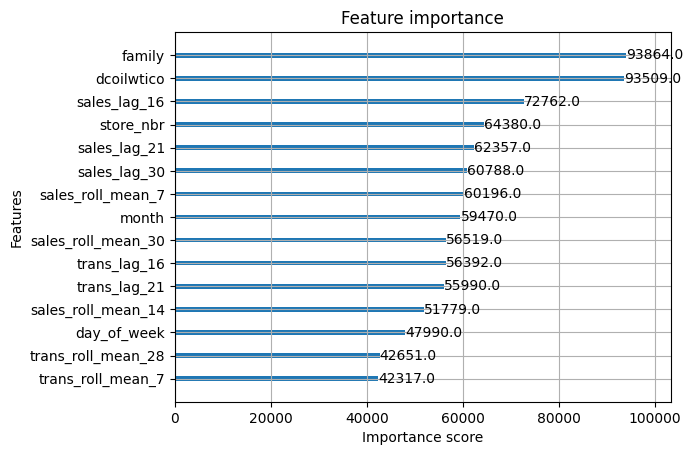

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

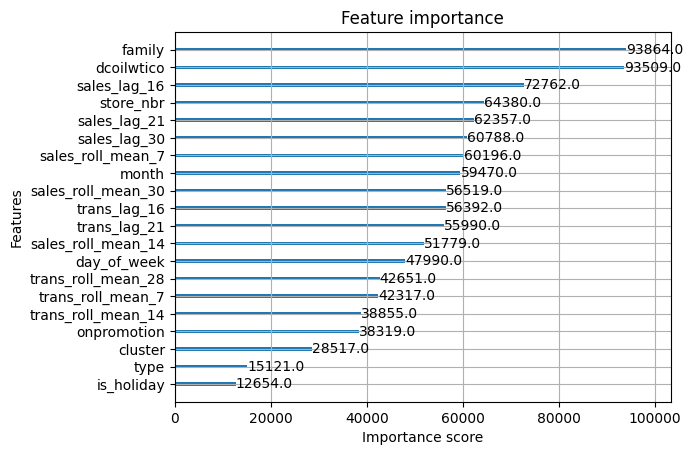

In [ ]:
# Celda 1: Imports y configuración de rutas
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1. Configuración de rutas
base_path = Path("..")
processed_path = base_path / "data" / "processed"

# 2. Cargar datos procesados
print("Cargando datos procesados...")
df = pd.read_parquet(processed_path / "train_features.parquet")

# VERIFICACIÓN: Ver estructura del dataframe
print("\n=== INFORMACIÓN DEL DATAFRAME ===")
print(f"Shape: {df.shape}")
print(f"\nColumnas disponibles:")
print(df.columns.tolist())
print(f"\n¿Está is_holiday?: {'is_holiday' in df.columns}")

# 3. Preparación de variables
# Convertimos categorías a códigos numéricos para XGBoost
df["family"] = df["family"].astype("category").cat.codes
df["city"] = df["city"].astype("category").cat.codes
df["state"] = df["state"].astype("category").cat.codes
df["type"] = df["type"].astype("category").cat.codes

# Definir columnas de características (Features) y objetivo (Target)
features = [
    "store_nbr",
    "family",
    "onpromotion",
    "type",
    "cluster",
    "month",
    "day_of_week",
    "is_weekend",
    "is_holiday",
    "dcoilwtico",
    "sales_lag_16",
    "sales_lag_21",
    "sales_lag_30",
    "sales_roll_mean_7",
    "sales_roll_mean_14",
    "sales_roll_mean_30",
    "trans_lag_16",
    "trans_lag_21",
    "trans_roll_mean_7",
    "trans_roll_mean_14",
    "trans_roll_mean_28",
]
target = "sales"
# 4. Split de Validación y Transformación Logarítmica
val_days = 30
split_date = df["date"].max() - pd.Timedelta(days=val_days)

train_data = df[df["date"] <= split_date]
valid_data = df[df["date"] > split_date]

# Aplicamos log1p (logaritmo de x + 1) para manejar ceros
y_train_log = np.log1p(train_data[target])
y_valid_log = np.log1p(valid_data[target])

X_train, X_valid = train_data[features], valid_data[features]

# 5. Entrenamiento con XGBoost (Optimizando para GPU)
print("Iniciando entrenamiento en GPU con Target Logarítmico...")
model = xgb.XGBRegressor(
    n_estimators=2000,  # Subimos porque ahora aprenderá más lento pero mejor
    learning_rate=0.03,  # Bajamos un poco para más precisión
    max_depth=10,  # Aumentamos profundidad para capturar más patrones
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    device="cuda",
    random_state=42,
    early_stopping_rounds=50,
)

# Pesos para optimizar WAPE
weights = np.log1p(train_data["sales"])

model.fit(
    X_train,
    y_train_log,
    sample_weight=weights,
    eval_set=[(X_valid, y_valid_log)],
    verbose=200,
)
# 6. Evaluación (RMSLE)
# Como entrenamos con log, la predicción ya está en escala logarítmica
preds_log = model.predict(X_valid)
preds_log = np.maximum(0, preds_log)  # Asegurar no negativos

# Para calcular el error real, comparamos log vs log (que es equivalente al RMSLE)
from sklearn.metrics import mean_squared_error

rmsle = np.sqrt(mean_squared_error(y_valid_log, preds_log))

print(f"\nRMSLE en Validación (con Log): {rmsle:.4f}")

# 7. Importancia de variables
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=15)
plt.show()
xgb.plot_importance(model, max_num_features=20)

In [18]:
# Guardar el modelo entrenado
model.save_model("../models/xgboost_model.json")
print("Modelo guardado en models/xgboost_model.json")

Modelo guardado en models/xgboost_model.json


In [19]:
# Cargar el modelo guardado
model_final = xgb.XGBRegressor()
model_final.load_model("../models/xgboost_model.json")

# Predecir sobre el set de validación (o el de test si ya lo procesaste)
# Recuerda aplicar expm1 porque entrenamos con logaritmo
final_preds = np.expm1(model_final.predict(X_valid))

print("Predicciones finales generadas exitosamente.")

Predicciones finales generadas exitosamente.


In [20]:
from sklearn.metrics import mean_absolute_percentage_error

# y_valid son las ventas reales en validación
# preds_log son las predicciones en escala log (las usamos para el RMSLE)

# Convertimos las predicciones logarítmicas a escala real de ventas
preds_real = np.expm1(preds_log)

# Para evitar divisiones por cero, filtramos filas donde la venta real es 0
mask = y_valid > 0
mape = mean_absolute_percentage_error(y_valid[mask], preds_real[mask]) * 100

print(f"MAPE en Validación: {mape:.2f}%")

MAPE en Validación: 40.94%


In [ ]:
from sklearn.metrics import mean_squared_error


def wape(y_true, y_pred):
    return (np.abs(y_true - y_pred).sum() / (y_true.sum() + 1e-12)) * 100


val_days = 15
split_date = df["date"].max() - pd.Timedelta(days=val_days)

train_data = df[df["date"] <= split_date].copy()
valid_data = df[df["date"] > split_date].copy()

X_train = train_data[features]
X_valid = valid_data[features]

y_train_log = np.log1p(train_data["sales"].values)
y_valid_log = np.log1p(valid_data["sales"].values)

model = xgb.XGBRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    device="cuda",
    random_state=42,
    early_stopping_rounds=50,
)

model.fit(X_train, y_train_log, eval_set=[(X_valid, y_valid_log)], verbose=200)

preds_log = model.predict(X_valid)
preds_log = np.maximum(preds_log, 0)

# RMSLE (en log)
rmsle = np.sqrt(mean_squared_error(y_valid_log, preds_log))

# WAPE (en escala real)
preds_real = np.expm1(preds_log)
y_valid_real = valid_data["sales"].values
wape_15 = wape(y_valid_real, preds_real)

print(f"RMSLE (15d): {rmsle:.4f}")
print(f"WAPE  (15d): {wape_15:.2f}%")

[0]	validation_0-rmse:2.53921
[200]	validation_0-rmse:0.41196
[400]	validation_0-rmse:0.40862
[600]	validation_0-rmse:0.40702
[800]	validation_0-rmse:0.40601
[1000]	validation_0-rmse:0.40522
[1200]	validation_0-rmse:0.40462
[1400]	validation_0-rmse:0.40414
[1600]	validation_0-rmse:0.40373
[1715]	validation_0-rmse:0.40355
RMSLE (15d): 0.4035
WAPE  (15d): 16.86%


In [ ]:
# 1. Recuperar nombres originales para el Dashboard
# Cargamos los nombres de las familias y ciudades para que el dashboard sea legible
stores_info = pd.read_csv("../data/raw/stores.csv")

# 2. Crear el dataframe de resultados de validación
df_results = valid_data[["date", "store_nbr", "family", "sales"]].copy()
df_results["prediction"] = np.expm1(preds_log)

# 3. Unir con información de tiendas para tener la ciudad/tipo
df_results = df_results.merge(
    stores_info[["store_nbr", "city", "state"]], on="store_nbr", how="left"
)

# 4. Guardar para el Dashboard
dashboard_path = Path("../dashboard")
dashboard_path.mkdir(exist_ok=True)
df_results.to_csv(dashboard_path / "data_forecast.csv", index=False)

print(f"Archivo para dashboard generado con {len(df_results)} filas.")

Archivo para dashboard generado con 26730 filas.
